# Examples of using ASDCache


## Using `SpectraCache` to cache data with ASDCache

`ASDCache` contains the `SpectraCache` class, which is the entrypoint to the cache and the ASD.

All instances of `SpectraCache` share the same `SQLite` cache file on the local system, located in the system's user cache directory.

The `SpectraCache` support either using `pandas` or `polars` as the dataframe backend for retrieved data.


In [1]:
from ASDCache import SpectraCache
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

nist = SpectraCache(use_polars_backend=False)

Let's perform a lookup of the lines for several different species.

Each `fetch` will return a `DataFrame` containing the data contained in the NIST ASD table.

Notice that the first time you run these commands it may take several seconds to retrieve the requested data, but subsequent repetitions are fast.

In [2]:
lines_H_I = nist.fetch("H I", wl_range=(170, 1000))  # This is the range used by default
lines_O_I_III = nist.fetch("O I-III")
lines_Ar_I_II = nist.fetch("Ar I-II")

In [3]:
%timeit lines_H_I = nist.fetch("H I")

10.3 ms ± 229 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Let's check out what is contained in the retrieved Dataframe.

If we inspect the head of the table, we can see numerous columns that contain relevant information for each line, such as term symbols, energy levels, wavelengths, element, ionization state and bibliographic reference code.

The names of these columns are consistent with those retrieved from the NIST ASD, when using the `Tab-separated` output option.

In [4]:
lines_H_I.head()

,element,sp_num,obs_wl_vac(nm),unc_obs_wl,obs_wl_air(nm),ritz_wl_vac(nm),unc_ritz_wl,ritz_wl_air(nm),wn(cm-1),intens,...,term_i,J_i,conf_k,term_k,J_k,g_i,g_k,Type,tp_ref,line_ref
0,H,1,NaN,NaN,NaN,365.61647,0.00013,365.512338,27351.065,NaN,...,NaN,NaN,40,NaN,NaN,8.0,3200.0,E1,T8637,NaN
1,H,1,NaN,NaN,NaN,365.66407,0.00013,365.559925,27347.505,NaN,...,NaN,NaN,39,NaN,NaN,8.0,3042.0,E1,T8637,NaN
2,H,1,NaN,NaN,NaN,365.71549,0.00013,365.611332,27343.660,NaN,...,NaN,NaN,38,NaN,NaN,8.0,2888.0,E1,T8637,NaN
3,H,1,365.769,0.003,365.664828,365.77116,0.00019,365.666988,27339.650,700.0,...,NaN,NaN,37,NaN,NaN,8.0,2738.0,E1,T8637,L7400c29
4,H,1,365.829,0.003,365.724813,365.83154,0.00019,365.727352,27335.160,700.0,...,NaN,NaN,36,NaN,NaN,8.0,2592.0,E1,T8637,L7400c29


## Plotting line positions

We can use the retrieved data to visualize line positions, based on e.g. their Einstein coefficient, to help us identify lines in a spectrum.

To make sure we plot the positions for each (`element`, `sp_num`) pair seperately (so that we can identify them), we make use of a `groupby` operation on the retrieved Dataframes.

The `sp_num` column contains the ionization degree of the element, where 1 signifies the non-ionized atom.

In addition, we filter the data down by only plotting lines that have a value in the `intens` column larger than 0, which corresponds to the `Rel. Int.` column in the online NIST ASD HTML table.

**Note:** by convention `ASDCache` uses the column names of the tab-separated ASD output, not the column labels of the human-readable HTML formatted table.

The ionization states are contained in the `sp_num` column, where the value `1` corresponds to the ground state.

The NIST ASD tends to use roman numerals when querying a specific state (i.e. `H I`), but returns integers when retrieving data for different states (i.e. `O I-III`).

`ASDCache` always uses integers to represent this data, such that we can filter this data based on comparisons like `>` or `<=`.

Using a numeric data type also brings performance benefits, though these are likely insignificant.

Text(0, 0.5, 'A$_{ki}$ $(\\mathrm{s}^{-1})$')

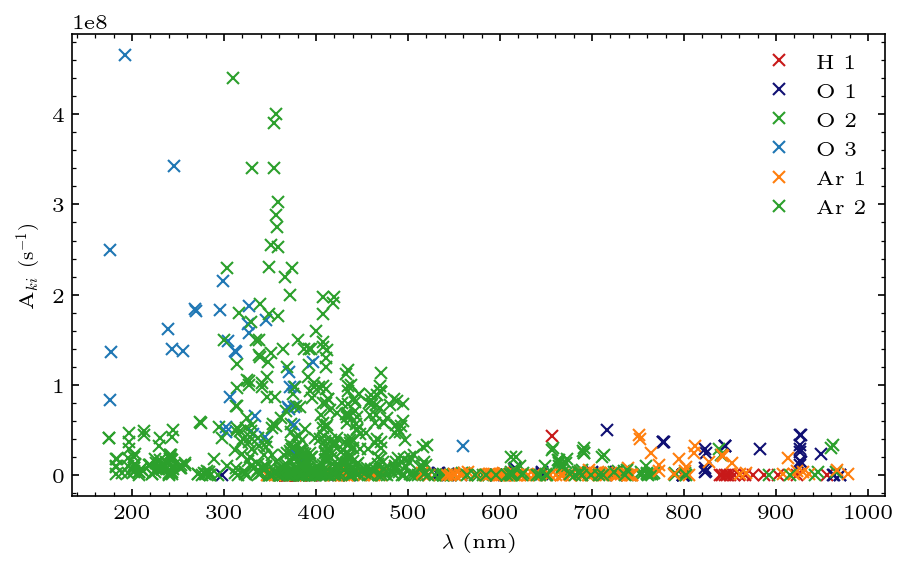

In [5]:
for lines_set in [lines_H_I, lines_O_I_III, lines_Ar_I_II]:
    for lower, lines in lines_set[lines_set.intens.notna()].groupby(["element", "sp_num"]):
        plt.plot(lines["obs_wl_vac(nm)"], lines["Aki(s^-1)"], marker="x", ls="none", label=f"{lower[0]} {lower[1]}")
plt.legend()
plt.xlabel(r"$\lambda$ (nm)")
plt.ylabel(r"A$_{ki}$ $(\mathrm{s}^{-1})$")

## Compute a simple stick spectrum

Instead of simply plotting data retrieved from the ASD directly, we can also use the retrieved information to drive some calculations.

We can calculate spectra (or rather line intensities) at different electron temperature $T_e$.

In principle, you need to account for the abundance of each element, and then account for the respective ionization energies in calculating the ionization partition sum, when assuming a local thermodynamic equilibrium (LTE).

For sake of simplicity, this example will plot several different atoms/ions while ignoring different populations and statistical weight for each species.

In other words: we skip calculating a distribution function between the different species and only use the electron temperature $T_e$ to calculate the population distribution of the different states within each species (a particular atom/ion), to arrive at a photon emission rate per volume for each emitting upper state $k$:

$\phi_{photon}\propto g_k\cdot A_{ki}\cdot \exp(-E_k/T_e)$.

We thus implicitly assume a Maxwellian distribution for the electron energy distribution function (EEDF), parameterized by $T_e$.

Notice in the plot below that $\mathrm{Ar}^+ $ and $\mathrm{O}^+ $ become more prominent at higher $T_e$, as their strongly emitting higher energy states become more populated (see above).

This is separate from the change in their respective population fraction (w.r.t. the ground state) for different $T_e$ that you would expect for an LTE plasma (since we ignore this effect here).

Also notice that we only select electric dipole-allowed (E1) transitions, by filtering using the criterium `lines_set.Type=="E1"`.

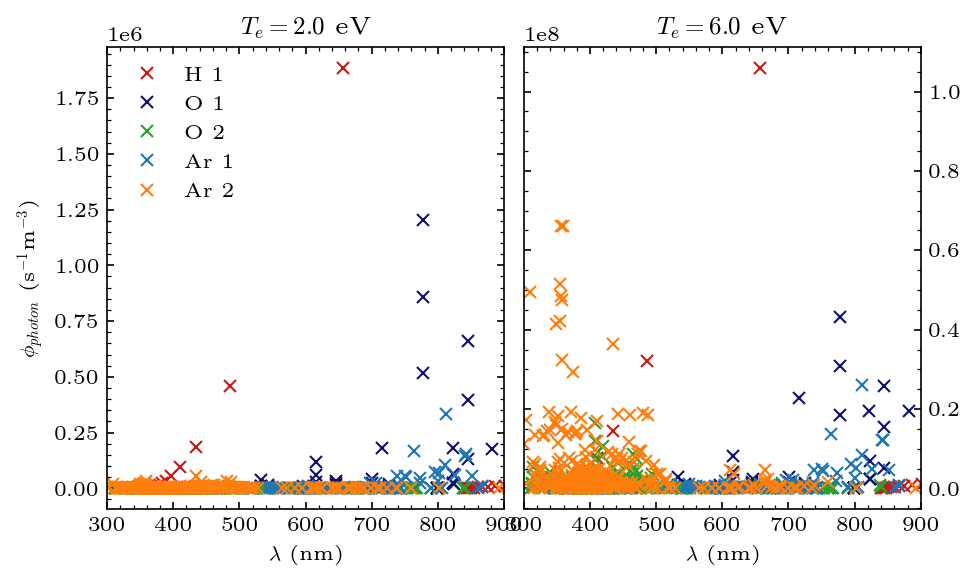

In [6]:
eV_in_wn = 8065.544  # express energy in eV

fig, ax = plt.subplots(1, 2, sharex=True, sharey=False, gridspec_kw={"wspace": 0.05})

for i, Te in enumerate([2, 6]):
    for lines_set in [lines_H_I, lines_O_I_III, lines_Ar_I_II]:
        for lower, lines in lines_set[
            (lines_set.sp_num < 3) & (lines_set.Type == "E1") & (lines_set.intens.notna())
        ].groupby(["element", "sp_num"]):
            ax[i].plot(
                lines["obs_wl_vac(nm)"],
                lines["Aki(s^-1)"] * lines.g_k * np.exp(-lines["Ek(cm-1)"] / eV_in_wn / Te),
                marker="x",
                ls="none",
                label=f"{lower[0]} {lower[1]}",
            )
    ax[i].set_title(f"$T_e={Te:.1f}$ eV", ha="center")

ax[0].legend()
for a in ax:
    a.set_xlabel(r"$\lambda$ (nm)")
plt.xlim(300, 900)
ax[0].set_ylabel(r"$\phi_{photon}$ (s$^{-1}$m$^{-3}$)")

ax[1].tick_params(labelleft=False, labelright=True)
ax[1].yaxis.set_label_position("right")

## Simulate the spectrum

From the generated stick spectrum it becomes fairly trivial to simulate a spectrum (though we use crude assumptions and filtering in this example).

Here we rely on [Moose](https://github.com/AntoineTUE/Moose) to transform the stick spectrum into a uniformally broadened spectrum, and plot spectra for different $T_e$, using the assumptions above.

First we use `Moose.equidistant_mesh` to bin the contributions of all lines on an equidistant wavelength axis.

Following this, a spectrum subject to voigt broadening is calculated with `Moose.apply_voigt`, with both Gaussian and Lorentzian broadening equal to 0.3 nm.

Once more, bear in mind that in practice you should account for the different population fractions of each species and that the electron energy distribution function may not be represented by a Maxwellian.

The results plotted below are normalized on the interval [0,1].

In [7]:
import Moose

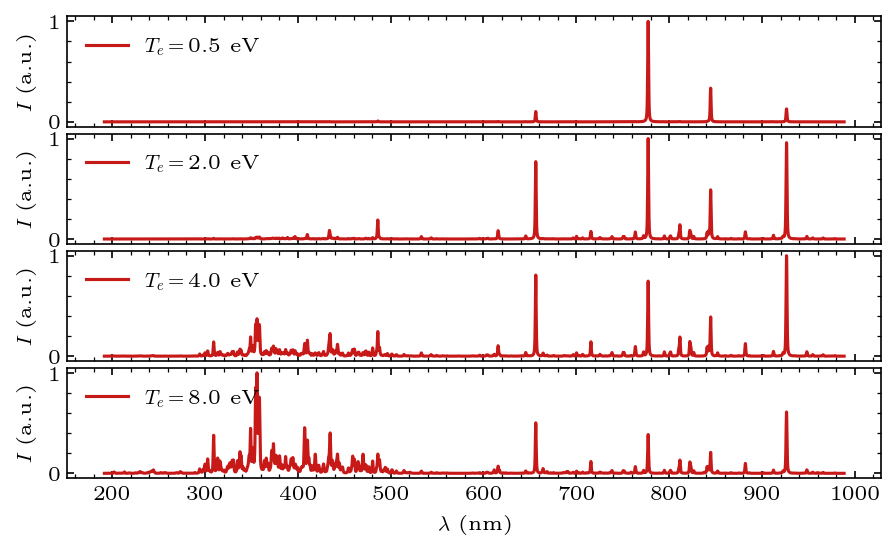

In [8]:
all_lines = pd.concat([lines_H_I, lines_O_I_III, lines_Ar_I_II]).sort_values("obs_wl_air(nm)")
all_allowed_lines = all_lines[(all_lines.Type == "E1") & (all_lines.intens.notna())]

fig, ax = plt.subplots(4, 1, sharex=True, sharey=True, gridspec_kw={"hspace": 0.06})
for i, Te in enumerate([0.5, 2, 4, 8]):
    spec = Moose.apply_voigt(
        Moose.equidistant_mesh(
            pd.DataFrame(
                np.array(
                    [
                        all_allowed_lines["obs_wl_air(nm)"],
                        all_allowed_lines["Aki(s^-1)"]
                        * all_allowed_lines["g_k"]
                        * np.exp(-all_allowed_lines["Ek(cm-1)"] / eV_in_wn / Te),
                    ]
                ).T
            )
            .dropna()
            .to_numpy()
        ),
        0.3,
        0.3,
        False,
    )
    ax[i].plot(
        spec[:, 0], (spec[:, 1] - spec[:, 1].min()) / (spec[:, 1].max() - spec[:, 1].min()), label=f"$T_e=${Te:.1f} eV"
    )
    ax[i].legend(loc="upper left")
plt.xlabel(r"$\lambda$ (nm)")

for a in ax:
    a.set_ylabel("$I$ (a.u.)")

Alternatively, we can also compare the spectra for different $T_e$ for each species, to develop our understanding of which lines could contribute to an experimentally observed spectrum.

To that effect, let's once more take all allowed dipole transitions and group them by their (`element`, `sp_num`).

We repeat the same calculation as above, but now separately for each species.

We thus skip any assumptions on their respective population fractions and only consider the distribution across states for the given species at a given $T_e$. 

Note that once more, we normalize the spectra to [0,1] for clarity.

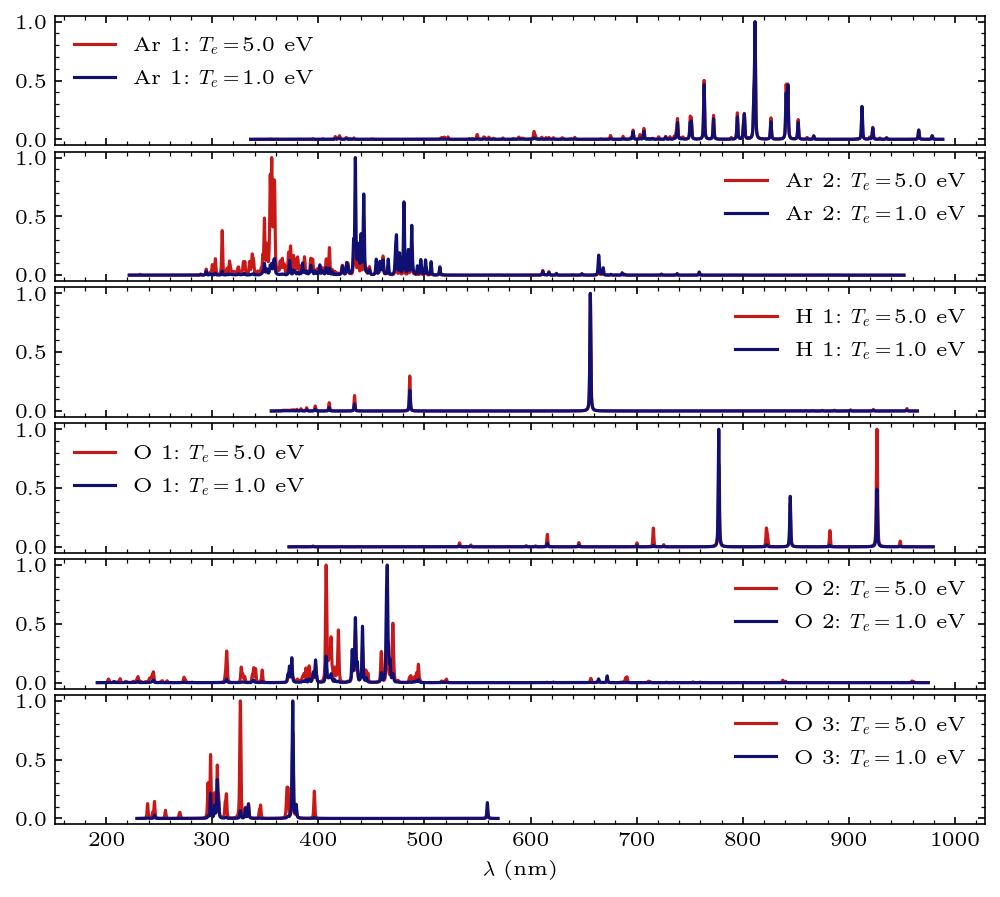

In [9]:
n_species = all_allowed_lines.groupby(["element", "sp_num"]).ngroups
fig, ax = plt.subplots(
    n_species, 1, sharey=True, sharex=True, gridspec_kw={"wspace": 0.03, "hspace": 0.05}, figsize=(8, 7)
)

for i, (specie, lines) in enumerate(all_allowed_lines.groupby(["element", "sp_num"])):
    for Te in [5, 1]:
        spec = Moose.apply_voigt(
            Moose.equidistant_mesh(
                pd.DataFrame(
                    np.array(
                        [
                            lines["obs_wl_air(nm)"],
                            lines["Aki(s^-1)"] * lines["g_k"] * np.exp(-lines["Ek(cm-1)"] / eV_in_wn / Te),
                        ]
                    ).T
                )
                .dropna()
                .to_numpy()
            ),
            0.3,
            0.3,
            False,
        )
        ax[i].plot(
            spec[:, 0],
            (spec[:, 1] - spec[:, 1].min()) / (spec[:, 1].max() - spec[:, 1].min()),
            label=f"{specie[0]} {specie[1]}: $T_e=${Te:.1f} eV",
        )
    ax[i].legend()

for a in ax:
    a.set_xlabel(r"$\lambda$ (nm)")